In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from os import path

from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

from typing import Tuple, List, Dict

from datetime import datetime

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

from collections import Counter

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Import dataset

In [3]:
data = pd.read_csv('Dataset/UNSW_NB15_training-set.csv')

print("Kolom UNSW:", data.columns)

Kolom UNSW: Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


# Data Preparation

## EDA

In [4]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [6]:
data.isna().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

## Data Visualization

Class distribution: ransomware vs normal:
label
1    119341
0     56000
Name: count, dtype: int64


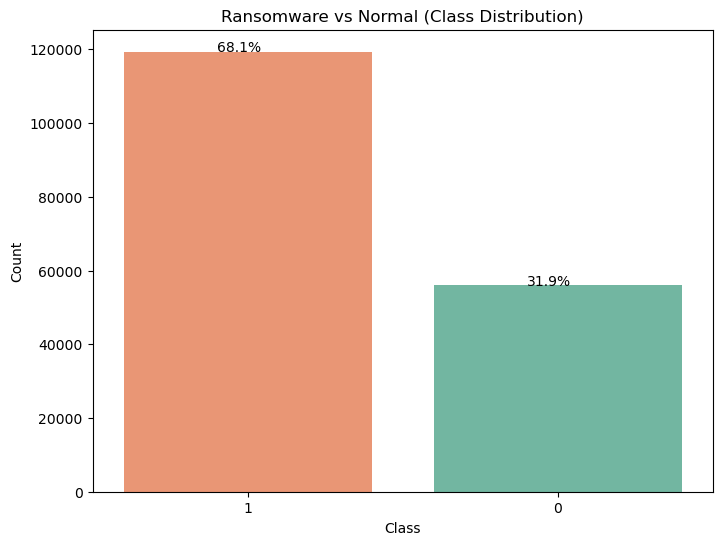

In [7]:
if 'label' in data.columns:
    print("Class distribution: ransomware vs normal:")
    class_counts = data['label'].value_counts()
    print(class_counts)

    # Plot the distribution of classes
    plt.figure(figsize=(8, 6))

    ax = sns.countplot(data=data, x='label', hue='label', order=class_counts.index, palette='Set2', legend=False)
    plt.xticks(rotation=0)
    plt.title('Ransomware vs Normal (Class Distribution)')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Add percentages on top of the bars
    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 5
        ax.annotate(percentage, (x, y))

    # Save the figure
    plt.savefig('Visualisasi/persebaran_data.png')

    # Show the figure
    plt.show()

# Pre-processing Data

In [8]:
MODALITIES = {
    'flow': ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',
             'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss'],
    'time': ['sinpkt', 'dinpkt', 'sjit', 'djit'],
    'window': ['swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat'],
    'packet': ['smean', 'dmean'],
    'connection': ['trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl',
                   'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'],
    'protocol': ['proto', 'service', 'state'],
    'ftp': ['is_ftp_login', 'ct_ftp_cmd'],
    'http': ['ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
}

In [9]:
data['label'] = data['label'].map({0: 'Normal', 1: 'Ransomware'})
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
def preprocess_modalities(df: pd.DataFrame) -> tuple[dict[str, np.ndarray], np.ndarray]:
    processed_data = {}

    for modality, features in MODALITIES.items():
        if set(features).issubset(df.columns):
            modal_data = df[features].copy()

            categorical_cols = modal_data.select_dtypes(include=['object']).columns
            for col in categorical_cols:
                le = LabelEncoder()
                modal_data[col] = le.fit_transform(modal_data[col].astype(str))

            scaler = MinMaxScaler()
            processed_data[modality] = scaler.fit_transform(modal_data)

    le_labels = LabelEncoder()
    labels = le_labels.fit_transform(df['label'])

    return processed_data, labels

processed_train_data, train_labels = preprocess_modalities(train_df)
processed_test_data, test_labels = preprocess_modalities(test_df)

In [11]:
def apply_smote(data: dict[str, np.ndarray], labels: np.ndarray) -> tuple[dict[str, np.ndarray], np.ndarray]:
    smote = SMOTE(random_state=42)
    balanced_data = {}

    combined_data = np.hstack([data[modality] for modality in data])

    combined_data_res, labels_res = smote.fit_resample(combined_data, labels)

    start_idx = 0
    for modality, features in MODALITIES.items():
        end_idx = start_idx + data[modality].shape[1]
        balanced_data[modality] = combined_data_res[:, start_idx:end_idx]
        start_idx = end_idx

    return balanced_data, labels_res

balanced_train_data, balanced_train_labels = apply_smote(processed_train_data, train_labels)

unique, counts = np.unique(balanced_train_labels, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")

Class distribution after SMOTE: {0: 95441, 1: 95441}


In [12]:
class MultiModalDataset(Dataset):
    def __init__(self, data: dict[str, torch.Tensor], labels: torch.Tensor):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.data.items()}, self.labels[idx]

In [13]:
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        return self.fc(x)

In [14]:
class TransformerDecoderModel(nn.Module):
    def __init__(self, modalities: dict, embed_dim: int, nhead: int, num_layers: int, num_classes: int):
        """
        Args:
            modalities (dict): Dictionary where keys are modality names, and values are input dimensions.
            embed_dim (int): Embedding dimension for Transformer.
            nhead (int): Number of attention heads.
            num_layers (int): Number of Transformer decoder layers.
            num_classes (int): Number of output classes.
        """
        super().__init__()
        
        self.modality_encoders = nn.ModuleDict({
            modality: ModalityEncoder(input_dim, embed_dim)
            for modality, input_dim in modalities.items()
        })

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.query_embedding = nn.Parameter(torch.randn(1, embed_dim))

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, data):
        """
        Args:
            data (dict): Dictionary where keys are modality names, and values are tensors with shape (batch_size, feature_dim).

        Returns:
            torch.Tensor: Predicted class logits with shape (batch_size, num_classes).
        """
        encoded_modalities = []
        for modality, encoder in self.modality_encoders.items():
            encoded_modalities.append(encoder(data[modality]))

        encoded_modalities = torch.stack(encoded_modalities, dim=1)
        batch_size = encoded_modalities.size(0)

        memory = encoded_modalities.permute(1, 0, 2)
        query = self.query_embedding.expand(1, batch_size, -1)

        decoder_output = self.transformer_decoder(tgt=query, memory=memory)
        aggregated_features = decoder_output.squeeze(0)
        logits = self.classifier(aggregated_features)
        return logits

In [15]:
# Define the training function for one epoch
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> tuple[float, float]:
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_data, labels in tqdm(train_loader, desc="Training", leave=False):
        # Move data to device
        batch_data = {
            modality: features.to(device).float()
            for modality, features in batch_data.items()
        }
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), correct / total

# Define the validation function
def validate(model: nn.Module,
             val_loader: DataLoader,
             criterion: nn.Module,
             device: torch.device) -> tuple[float, float, list[int], list[float]]:
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch_data, labels in tqdm(val_loader, desc="Validating", leave=False):
            # Move data to device
            batch_data = {
                modality: features.to(device).float()
                for modality, features in batch_data.items()
            }
            labels = labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_labels, all_preds, all_probs

In [16]:
# Define a class to handle model checkpoints
class ModelCheckpoint:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.best_val_acc = 0

    def save_checkpoint(self, model: nn.Module, val_acc: float, fold: int, epoch: int):
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'fold': fold,
                'epoch': epoch,
                'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            }
            os.makedirs(os.path.dirname(self.filepath), exist_ok=True)
            torch.save(checkpoint, self.filepath)
            return True
        return False

# Define a class to handle training history
class TrainingHistory:
    def __init__(self):
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'fold_metrics': {}
        }

    def update(self, fold: int, epoch: int, metrics: dict):
        if fold not in self.history['fold_metrics']:
            self.history['fold_metrics'][fold] = []

        self.history['fold_metrics'][fold].append({
            'epoch': epoch + 1,  # Adjust epoch to start from 1
            **metrics
        })

    def plot_metrics(self, fold: int):
        metrics = pd.DataFrame(self.history['fold_metrics'][fold])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss')
        ax1.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
        ax1.set_title(f'Model Loss - Fold {fold + 1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy plot
        ax2.plot(metrics['epoch'], metrics['train_acc'], label='Training Accuracy')
        ax2.plot(metrics['epoch'], metrics['val_acc'], label='Validation Accuracy')
        ax2.set_title(f'Model Accuracy - Fold {fold + 1}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, fold: int):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def print_classification_report(self, y_true, y_pred, fold: int):
        print(f"\nClassification Report - Fold {fold + 1}")
        print(classification_report(y_true, y_pred))

In [17]:
# Define the training function with k-fold cross-validation
def train_model_with_kfold(
    model: nn.Module,
    dataset: Dataset,
    n_splits: int = 5,
    num_epochs: int = 4,
    batch_size: int = 32,
    device: torch.device = device
) -> tuple[nn.Module, TrainingHistory]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()
    history = TrainingHistory()
    checkpoint = ModelCheckpoint('models/best_model_balance.pth')

    best_fold_metrics = {
        'fold': -1,
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'specificity': 0,
        'roc_auc': 0
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-" * 40)

        # Create data loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=train_subsampler
        )
        val_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=val_subsampler
        )

        # Reset model for each fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device
            )

            # Validation
            val_loss, val_acc, val_labels, val_preds, val_probs = validate(
                model, val_loader, criterion, device
            )

            # Update history
            history.update(fold, epoch, {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            print("-" * 40)

            # Save checkpoint if best model
            checkpoint.save_checkpoint(model, val_acc, fold, epoch)

        # Calculate final metrics for this fold
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch_data, labels in tqdm(val_loader, desc=f"Evaluating Fold {fold + 1}", leave=False):
                batch_data = {k: v.to(device).float() for k, v in batch_data.items()}
                outputs = model(batch_data)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted'
        )
        accuracy = accuracy_score(all_labels, all_preds)
        specificity = confusion_matrix(all_labels, all_preds)[0, 0] / (confusion_matrix(all_labels, all_preds)[0, 0] + confusion_matrix(all_labels, all_preds)[0, 1])
        roc_auc = roc_auc_score(all_labels, all_probs)

        # Update best fold metrics
        if accuracy > best_fold_metrics['accuracy']:
            best_fold_metrics.update({
                'fold': fold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'specificity': specificity,
                'roc_auc': roc_auc
            })

        # Plot fold results
        history.plot_metrics(fold)
        history.plot_confusion_matrix(all_labels, all_preds, fold)
        history.print_classification_report(all_labels, all_preds, fold)

    # Print final report
    print("\nFinal Report")
    print("=" * 40)
    print(f"Best Fold: {best_fold_metrics['fold'] + 1}")
    print(f"Best Accuracy: {best_fold_metrics['accuracy']:.4f}")
    print(f"Best Precision: {best_fold_metrics['precision']:.4f}")
    print(f"Best Recall: {best_fold_metrics['recall']:.4f}")
    print(f"Best F1 Score: {best_fold_metrics['f1']:.4f}")
    print(f"Best Specificity: {best_fold_metrics['specificity']:.4f}")
    print(f"Best ROC-AUC: {best_fold_metrics['roc_auc']:.4f}")

    return model, history


Fold 1/5
----------------------------------------


Epoch 1/30
Train Loss: 0.2396 - Train Acc: 0.8873 - Val Loss: 0.2583 - Val Acc: 0.8860
----------------------------------------


Epoch 2/30
Train Loss: 0.2373 - Train Acc: 0.8837 - Val Loss: 0.1962 - Val Acc: 0.8977
----------------------------------------


Epoch 3/30
Train Loss: 0.1843 - Train Acc: 0.9116 - Val Loss: 0.1570 - Val Acc: 0.9214
----------------------------------------


Epoch 4/30
Train Loss: 0.1667 - Train Acc: 0.9195 - Val Loss: 0.1664 - Val Acc: 0.9228
----------------------------------------


Epoch 5/30
Train Loss: 0.1603 - Train Acc: 0.9222 - Val Loss: 0.1452 - Val Acc: 0.9257
----------------------------------------


Epoch 6/30
Train Loss: 0.1547 - Train Acc: 0.9232 - Val Loss: 0.1414 - Val Acc: 0.9275
----------------------------------------


Epoch 7/30
Train Loss: 0.1521 - Train Acc: 0.9245 - Val Loss: 0.1452 - Val Acc: 0.9309
----------------------------------------


Epoch 8/30
Train Loss: 0.1477 - Train Acc: 0.9277 - Val Loss: 0.1419 - Val Acc: 0.9316
----------------------------------------


Epoch 9/30
Train Loss: 0.1463 - Train Acc: 0.9280 - Val Loss: 0.1494 - Val Acc: 0.9254
----------------------------------------


Epoch 10/30
Train Loss: 0.1471 - Train Acc: 0.9275 - Val Loss: 0.1351 - Val Acc: 0.9307
----------------------------------------


Epoch 11/30
Train Loss: 0.1448 - Train Acc: 0.9289 - Val Loss: 0.1314 - Val Acc: 0.9333
----------------------------------------


Epoch 12/30
Train Loss: 0.1408 - Train Acc: 0.9306 - Val Loss: 0.1376 - Val Acc: 0.9355
----------------------------------------


Epoch 13/30
Train Loss: 0.1393 - Train Acc: 0.9314 - Val Loss: 0.1273 - Val Acc: 0.9360
----------------------------------------


Epoch 14/30
Train Loss: 0.1373 - Train Acc: 0.9326 - Val Loss: 0.1411 - Val Acc: 0.9351
----------------------------------------


Epoch 15/30
Train Loss: 0.1375 - Train Acc: 0.9328 - Val Loss: 0.1286 - Val Acc: 0.9362
----------------------------------------


Epoch 16/30
Train Loss: 0.1354 - Train Acc: 0.9336 - Val Loss: 0.1286 - Val Acc: 0.9369
----------------------------------------


Epoch 17/30
Train Loss: 0.1357 - Train Acc: 0.9331 - Val Loss: 0.1278 - Val Acc: 0.9375
----------------------------------------


Epoch 18/30
Train Loss: 0.1345 - Train Acc: 0.9335 - Val Loss: 0.1406 - Val Acc: 0.9259
----------------------------------------


Epoch 19/30
Train Loss: 0.1342 - Train Acc: 0.9343 - Val Loss: 0.1239 - Val Acc: 0.9376
----------------------------------------


Epoch 20/30
Train Loss: 0.1330 - Train Acc: 0.9349 - Val Loss: 0.1247 - Val Acc: 0.9390
----------------------------------------


Epoch 21/30
Train Loss: 0.1319 - Train Acc: 0.9353 - Val Loss: 0.1268 - Val Acc: 0.9381
----------------------------------------


Epoch 22/30
Train Loss: 0.1330 - Train Acc: 0.9353 - Val Loss: 0.1298 - Val Acc: 0.9374
----------------------------------------


Epoch 23/30
Train Loss: 0.1331 - Train Acc: 0.9350 - Val Loss: 0.1293 - Val Acc: 0.9355
----------------------------------------


Epoch 24/30
Train Loss: 0.1316 - Train Acc: 0.9352 - Val Loss: 0.1239 - Val Acc: 0.9395
----------------------------------------


Epoch 25/30
Train Loss: 0.1311 - Train Acc: 0.9357 - Val Loss: 0.1318 - Val Acc: 0.9349
----------------------------------------


Epoch 26/30
Train Loss: 0.1295 - Train Acc: 0.9364 - Val Loss: 0.1228 - Val Acc: 0.9382
----------------------------------------


Epoch 27/30
Train Loss: 0.1295 - Train Acc: 0.9366 - Val Loss: 0.1223 - Val Acc: 0.9385
----------------------------------------


Epoch 28/30
Train Loss: 0.1295 - Train Acc: 0.9367 - Val Loss: 0.1297 - Val Acc: 0.9342
----------------------------------------


Epoch 29/30
Train Loss: 0.1290 - Train Acc: 0.9364 - Val Loss: 0.1239 - Val Acc: 0.9390
----------------------------------------


Epoch 30/30
Train Loss: 0.1293 - Train Acc: 0.9367 - Val Loss: 0.1217 - Val Acc: 0.9409
----------------------------------------


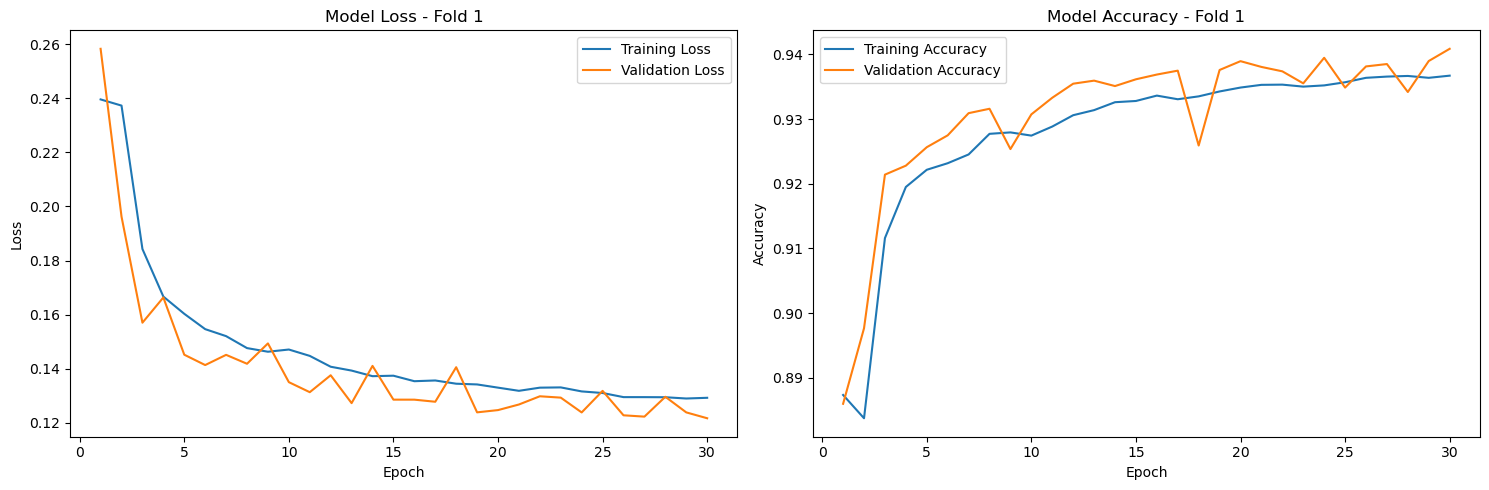

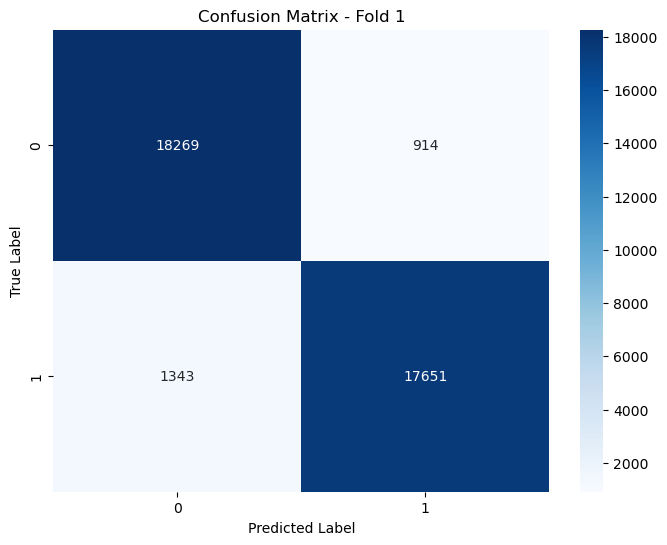


Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     19183
           1       0.95      0.93      0.94     18994

    accuracy                           0.94     38177
   macro avg       0.94      0.94      0.94     38177
weighted avg       0.94      0.94      0.94     38177


Fold 2/5
----------------------------------------


Epoch 1/30
Train Loss: 0.2641 - Train Acc: 0.8802 - Val Loss: 0.2582 - Val Acc: 0.8809
----------------------------------------


Epoch 2/30
Train Loss: 0.2554 - Train Acc: 0.8797 - Val Loss: 0.1834 - Val Acc: 0.9016
----------------------------------------


Epoch 3/30
Train Loss: 0.2117 - Train Acc: 0.8867 - Val Loss: 0.1621 - Val Acc: 0.9055
----------------------------------------


Epoch 4/30
Train Loss: 0.1899 - Train Acc: 0.8969 - Val Loss: 0.1573 - Val Acc: 0.9114
----------------------------------------


Epoch 5/30
Train Loss: 0.1753 - Train Acc: 0.9024 - Val Loss: 0.1493 - Val Acc: 0.9099
----------------------------------------


Epoch 6/30
Train Loss: 0.1663 - Train Acc: 0.9058 - Val Loss: 0.1512 - Val Acc: 0.9155
----------------------------------------


Epoch 7/30
Train Loss: 0.1617 - Train Acc: 0.9087 - Val Loss: 0.1452 - Val Acc: 0.9196
----------------------------------------


Epoch 8/30
Train Loss: 0.1793 - Train Acc: 0.9087 - Val Loss: 0.1566 - Val Acc: 0.9235
----------------------------------------


Epoch 9/30
Train Loss: 0.1670 - Train Acc: 0.9189 - Val Loss: 0.1619 - Val Acc: 0.9269
----------------------------------------


Epoch 10/30
Train Loss: 0.1607 - Train Acc: 0.9201 - Val Loss: 0.1456 - Val Acc: 0.9265
----------------------------------------


Epoch 11/30
Train Loss: 0.1544 - Train Acc: 0.9234 - Val Loss: 0.1445 - Val Acc: 0.9292
----------------------------------------


Epoch 12/30
Train Loss: 0.1524 - Train Acc: 0.9249 - Val Loss: 0.1386 - Val Acc: 0.9300
----------------------------------------


Epoch 13/30
Train Loss: 0.1480 - Train Acc: 0.9264 - Val Loss: 0.1362 - Val Acc: 0.9325
----------------------------------------


Epoch 14/30
Train Loss: 0.1449 - Train Acc: 0.9289 - Val Loss: 0.1324 - Val Acc: 0.9350
----------------------------------------


Epoch 15/30
Train Loss: 0.1416 - Train Acc: 0.9306 - Val Loss: 0.1382 - Val Acc: 0.9347
----------------------------------------


Epoch 16/30
Train Loss: 0.1400 - Train Acc: 0.9318 - Val Loss: 0.1284 - Val Acc: 0.9373
----------------------------------------


Epoch 17/30
Train Loss: 0.1391 - Train Acc: 0.9328 - Val Loss: 0.1329 - Val Acc: 0.9373
----------------------------------------


Epoch 18/30
Train Loss: 0.1379 - Train Acc: 0.9330 - Val Loss: 0.1331 - Val Acc: 0.9347
----------------------------------------


Epoch 19/30
Train Loss: 0.1364 - Train Acc: 0.9334 - Val Loss: 0.1283 - Val Acc: 0.9374
----------------------------------------


Epoch 20/30
Train Loss: 0.1360 - Train Acc: 0.9345 - Val Loss: 0.1445 - Val Acc: 0.9343
----------------------------------------


Epoch 21/30
Train Loss: 0.1342 - Train Acc: 0.9358 - Val Loss: 0.1241 - Val Acc: 0.9388
----------------------------------------


Epoch 22/30
Train Loss: 0.1337 - Train Acc: 0.9356 - Val Loss: 0.1242 - Val Acc: 0.9409
----------------------------------------


Epoch 23/30
Train Loss: 0.1341 - Train Acc: 0.9357 - Val Loss: 0.1312 - Val Acc: 0.9344
----------------------------------------


Epoch 24/30
Train Loss: 0.1325 - Train Acc: 0.9361 - Val Loss: 0.1241 - Val Acc: 0.9416
----------------------------------------


Epoch 25/30
Train Loss: 0.1328 - Train Acc: 0.9354 - Val Loss: 0.1222 - Val Acc: 0.9417
----------------------------------------


Epoch 26/30
Train Loss: 0.1330 - Train Acc: 0.9365 - Val Loss: 0.1244 - Val Acc: 0.9397
----------------------------------------


Epoch 27/30
Train Loss: 0.1315 - Train Acc: 0.9367 - Val Loss: 0.1208 - Val Acc: 0.9405
----------------------------------------


Epoch 28/30
Train Loss: 0.1318 - Train Acc: 0.9364 - Val Loss: 0.1208 - Val Acc: 0.9404
----------------------------------------


Epoch 29/30
Train Loss: 0.1316 - Train Acc: 0.9371 - Val Loss: 0.1235 - Val Acc: 0.9394
----------------------------------------


Epoch 30/30
Train Loss: 0.1309 - Train Acc: 0.9367 - Val Loss: 0.1236 - Val Acc: 0.9389
----------------------------------------


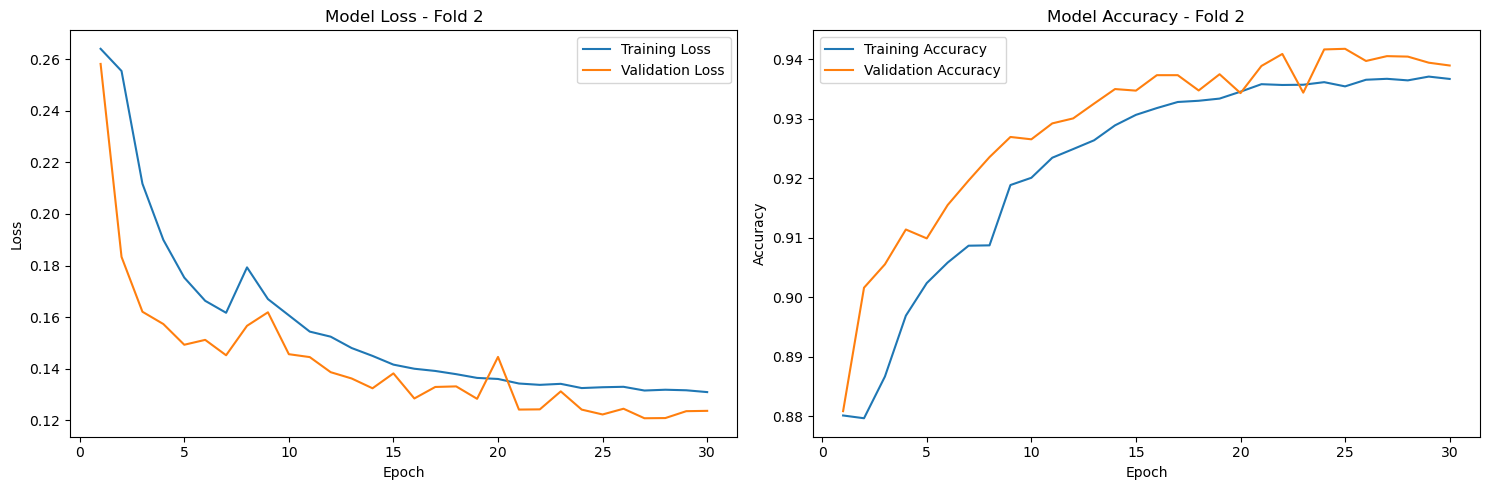

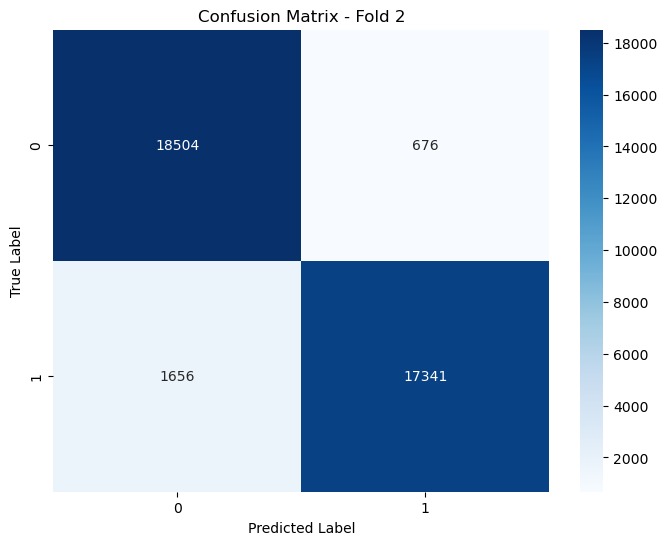


Classification Report - Fold 2
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     19180
           1       0.96      0.91      0.94     18997

    accuracy                           0.94     38177
   macro avg       0.94      0.94      0.94     38177
weighted avg       0.94      0.94      0.94     38177


Fold 3/5
----------------------------------------


Epoch 1/30
Train Loss: 0.2298 - Train Acc: 0.8941 - Val Loss: 0.1728 - Val Acc: 0.9171
----------------------------------------


Epoch 2/30
Train Loss: 0.1753 - Train Acc: 0.9144 - Val Loss: 0.1624 - Val Acc: 0.9192
----------------------------------------


Epoch 3/30
Train Loss: 0.1668 - Train Acc: 0.9187 - Val Loss: 0.1612 - Val Acc: 0.9229
----------------------------------------


Epoch 4/30
Train Loss: 0.1567 - Train Acc: 0.9230 - Val Loss: 0.1453 - Val Acc: 0.9305
----------------------------------------


Epoch 5/30
Train Loss: 0.1525 - Train Acc: 0.9247 - Val Loss: 0.1399 - Val Acc: 0.9300
----------------------------------------


Epoch 6/30
Train Loss: 0.1495 - Train Acc: 0.9262 - Val Loss: 0.1384 - Val Acc: 0.9318
----------------------------------------


Epoch 7/30
Train Loss: 0.1469 - Train Acc: 0.9266 - Val Loss: 0.1372 - Val Acc: 0.9306
----------------------------------------


Epoch 8/30
Train Loss: 0.1511 - Train Acc: 0.9263 - Val Loss: 0.1385 - Val Acc: 0.9327
----------------------------------------


Epoch 9/30
Train Loss: 0.1461 - Train Acc: 0.9278 - Val Loss: 0.1377 - Val Acc: 0.9330
----------------------------------------


Epoch 10/30
Train Loss: 0.1466 - Train Acc: 0.9282 - Val Loss: 0.1416 - Val Acc: 0.9328
----------------------------------------


Epoch 11/30
Train Loss: 0.1494 - Train Acc: 0.9274 - Val Loss: 0.1395 - Val Acc: 0.9331
----------------------------------------


Epoch 12/30
Train Loss: 0.1487 - Train Acc: 0.9274 - Val Loss: 0.1344 - Val Acc: 0.9330
----------------------------------------


Epoch 13/30
Train Loss: 0.1466 - Train Acc: 0.9273 - Val Loss: 0.1441 - Val Acc: 0.9315
----------------------------------------


Epoch 14/30
Train Loss: 0.1467 - Train Acc: 0.9285 - Val Loss: 0.1393 - Val Acc: 0.9339
----------------------------------------


Epoch 15/30
Train Loss: 0.1445 - Train Acc: 0.9279 - Val Loss: 0.1455 - Val Acc: 0.9277
----------------------------------------


Epoch 16/30
Train Loss: 0.1419 - Train Acc: 0.9287 - Val Loss: 0.1336 - Val Acc: 0.9335
----------------------------------------


Epoch 17/30
Train Loss: 0.1424 - Train Acc: 0.9283 - Val Loss: 0.1355 - Val Acc: 0.9324
----------------------------------------


Epoch 18/30
Train Loss: 0.1406 - Train Acc: 0.9289 - Val Loss: 0.1326 - Val Acc: 0.9329
----------------------------------------


Epoch 19/30
Train Loss: 0.1407 - Train Acc: 0.9296 - Val Loss: 0.1403 - Val Acc: 0.9342
----------------------------------------


Epoch 20/30
Train Loss: 0.1410 - Train Acc: 0.9293 - Val Loss: 0.1345 - Val Acc: 0.9325
----------------------------------------


Epoch 21/30
Train Loss: 0.1414 - Train Acc: 0.9302 - Val Loss: 0.1354 - Val Acc: 0.9328
----------------------------------------


Epoch 22/30
Train Loss: 0.1392 - Train Acc: 0.9310 - Val Loss: 0.1348 - Val Acc: 0.9327
----------------------------------------


Epoch 23/30
Train Loss: 0.1390 - Train Acc: 0.9309 - Val Loss: 0.1366 - Val Acc: 0.9332
----------------------------------------


Epoch 24/30
Train Loss: 0.1381 - Train Acc: 0.9314 - Val Loss: 0.1372 - Val Acc: 0.9330
----------------------------------------


Epoch 25/30
Train Loss: 0.1379 - Train Acc: 0.9322 - Val Loss: 0.1376 - Val Acc: 0.9308
----------------------------------------


Epoch 26/30
Train Loss: 0.1377 - Train Acc: 0.9317 - Val Loss: 0.1333 - Val Acc: 0.9316
----------------------------------------


Epoch 27/30
Train Loss: 0.1354 - Train Acc: 0.9327 - Val Loss: 0.1410 - Val Acc: 0.9307
----------------------------------------


Epoch 28/30
Train Loss: 0.1361 - Train Acc: 0.9331 - Val Loss: 0.1408 - Val Acc: 0.9325
----------------------------------------


Epoch 29/30
Train Loss: 0.1354 - Train Acc: 0.9324 - Val Loss: 0.1322 - Val Acc: 0.9338
----------------------------------------


Epoch 30/30
Train Loss: 0.1344 - Train Acc: 0.9332 - Val Loss: 0.1366 - Val Acc: 0.9335
----------------------------------------


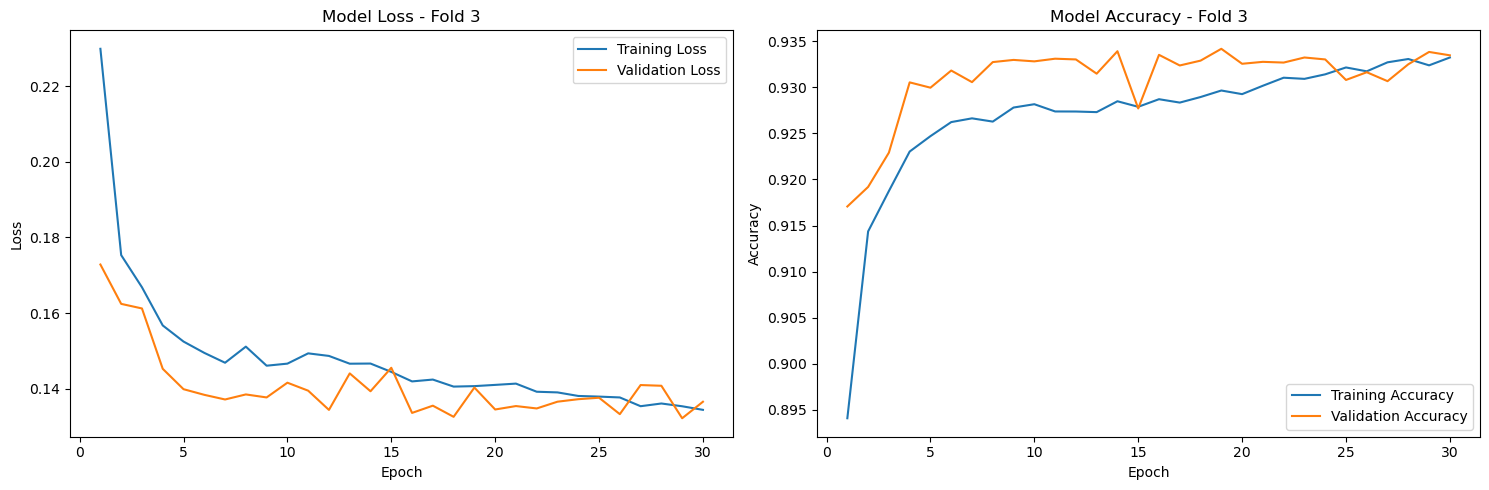

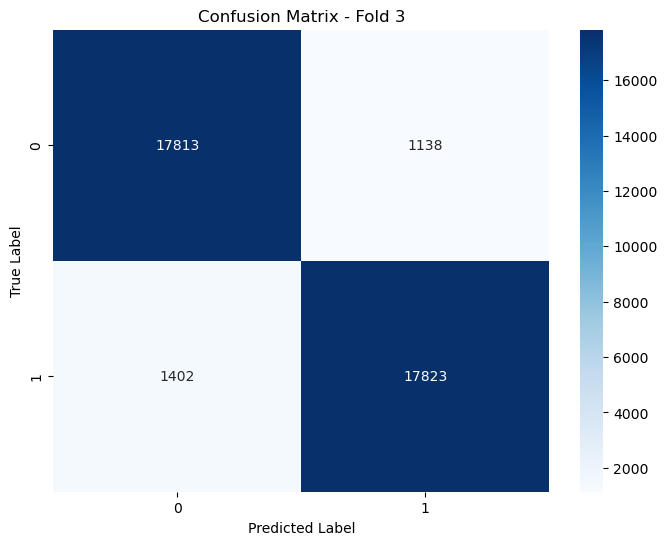


Classification Report - Fold 3
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18951
           1       0.94      0.93      0.93     19225

    accuracy                           0.93     38176
   macro avg       0.93      0.93      0.93     38176
weighted avg       0.93      0.93      0.93     38176


Fold 4/5
----------------------------------------


Epoch 1/30
Train Loss: 0.2464 - Train Acc: 0.8847 - Val Loss: 0.2133 - Val Acc: 0.8917
----------------------------------------


Epoch 2/30
Train Loss: 0.2172 - Train Acc: 0.8923 - Val Loss: 0.1991 - Val Acc: 0.8969
----------------------------------------


Epoch 3/30
Train Loss: 0.2076 - Train Acc: 0.8940 - Val Loss: 0.1859 - Val Acc: 0.9000
----------------------------------------


Epoch 4/30
Train Loss: 0.1860 - Train Acc: 0.9078 - Val Loss: 0.1755 - Val Acc: 0.9160
----------------------------------------


Epoch 5/30
Train Loss: 0.1714 - Train Acc: 0.9166 - Val Loss: 0.1543 - Val Acc: 0.9241
----------------------------------------


Epoch 6/30
Train Loss: 0.1680 - Train Acc: 0.9187 - Val Loss: 0.1448 - Val Acc: 0.9271
----------------------------------------


Epoch 7/30
Train Loss: 0.1635 - Train Acc: 0.9202 - Val Loss: 0.1420 - Val Acc: 0.9281
----------------------------------------


Epoch 8/30
Train Loss: 0.1616 - Train Acc: 0.9210 - Val Loss: 0.1443 - Val Acc: 0.9294
----------------------------------------


Epoch 9/30
Train Loss: 0.1600 - Train Acc: 0.9223 - Val Loss: 0.1566 - Val Acc: 0.9286
----------------------------------------


Epoch 10/30
Train Loss: 0.1580 - Train Acc: 0.9231 - Val Loss: 0.1618 - Val Acc: 0.9170
----------------------------------------


Epoch 11/30
Train Loss: 0.1577 - Train Acc: 0.9239 - Val Loss: 0.1393 - Val Acc: 0.9314
----------------------------------------


Epoch 12/30
Train Loss: 0.1544 - Train Acc: 0.9256 - Val Loss: 0.1445 - Val Acc: 0.9333
----------------------------------------


Epoch 13/30
Train Loss: 0.1507 - Train Acc: 0.9270 - Val Loss: 0.1427 - Val Acc: 0.9362
----------------------------------------


Epoch 14/30
Train Loss: 0.1459 - Train Acc: 0.9286 - Val Loss: 0.1353 - Val Acc: 0.9363
----------------------------------------


Epoch 15/30
Train Loss: 0.1471 - Train Acc: 0.9285 - Val Loss: 0.1334 - Val Acc: 0.9341
----------------------------------------


Epoch 16/30
Train Loss: 0.1440 - Train Acc: 0.9290 - Val Loss: 0.1360 - Val Acc: 0.9338
----------------------------------------


Epoch 17/30
Train Loss: 0.1432 - Train Acc: 0.9297 - Val Loss: 0.1310 - Val Acc: 0.9385
----------------------------------------


Epoch 18/30
Train Loss: 0.1410 - Train Acc: 0.9312 - Val Loss: 0.1297 - Val Acc: 0.9367
----------------------------------------


Epoch 19/30
Train Loss: 0.1405 - Train Acc: 0.9317 - Val Loss: 0.1316 - Val Acc: 0.9359
----------------------------------------


Epoch 20/30
Train Loss: 0.1374 - Train Acc: 0.9331 - Val Loss: 0.1340 - Val Acc: 0.9338
----------------------------------------


Epoch 21/30
Train Loss: 0.1359 - Train Acc: 0.9345 - Val Loss: 0.1276 - Val Acc: 0.9382
----------------------------------------


Epoch 22/30
Train Loss: 0.1346 - Train Acc: 0.9350 - Val Loss: 0.1291 - Val Acc: 0.9366
----------------------------------------


Epoch 23/30
Train Loss: 0.1336 - Train Acc: 0.9353 - Val Loss: 0.1244 - Val Acc: 0.9400
----------------------------------------


Epoch 24/30
Train Loss: 0.1326 - Train Acc: 0.9356 - Val Loss: 0.1262 - Val Acc: 0.9389
----------------------------------------


Epoch 25/30
Train Loss: 0.1323 - Train Acc: 0.9363 - Val Loss: 0.1234 - Val Acc: 0.9412
----------------------------------------


Epoch 26/30
Train Loss: 0.1314 - Train Acc: 0.9368 - Val Loss: 0.1242 - Val Acc: 0.9408
----------------------------------------


Epoch 27/30
Train Loss: 0.1327 - Train Acc: 0.9364 - Val Loss: 0.1221 - Val Acc: 0.9400
----------------------------------------


Epoch 28/30
Train Loss: 0.1315 - Train Acc: 0.9365 - Val Loss: 0.1254 - Val Acc: 0.9394
----------------------------------------


Epoch 29/30
Train Loss: 0.1305 - Train Acc: 0.9371 - Val Loss: 0.1242 - Val Acc: 0.9409
----------------------------------------


Epoch 30/30
Train Loss: 0.1298 - Train Acc: 0.9370 - Val Loss: 0.1215 - Val Acc: 0.9401
----------------------------------------


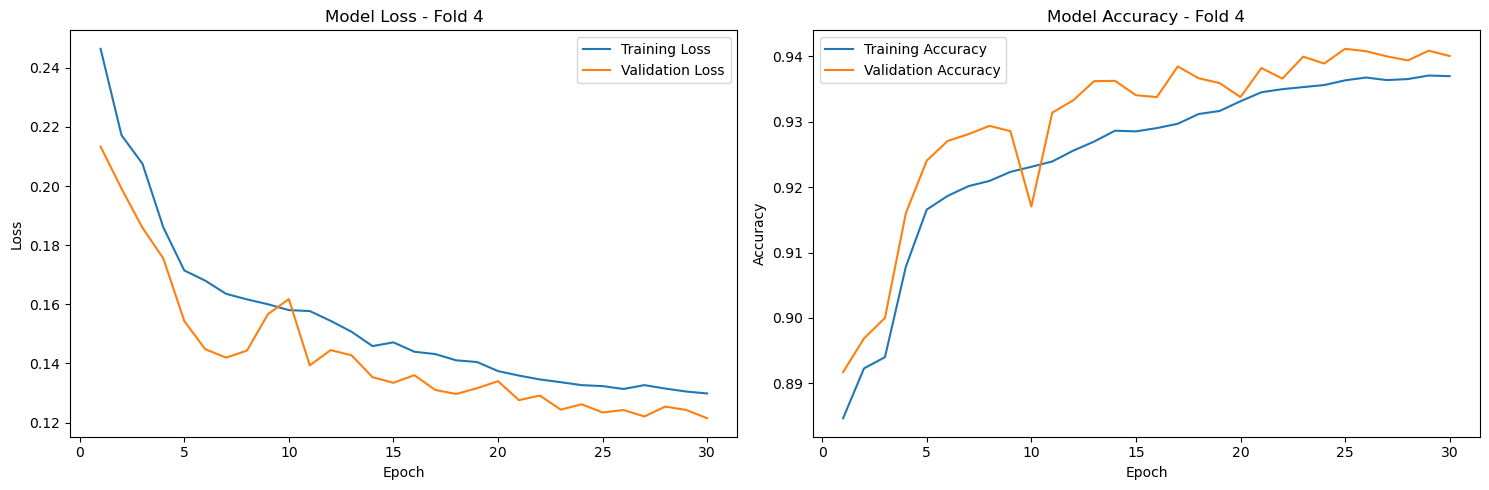

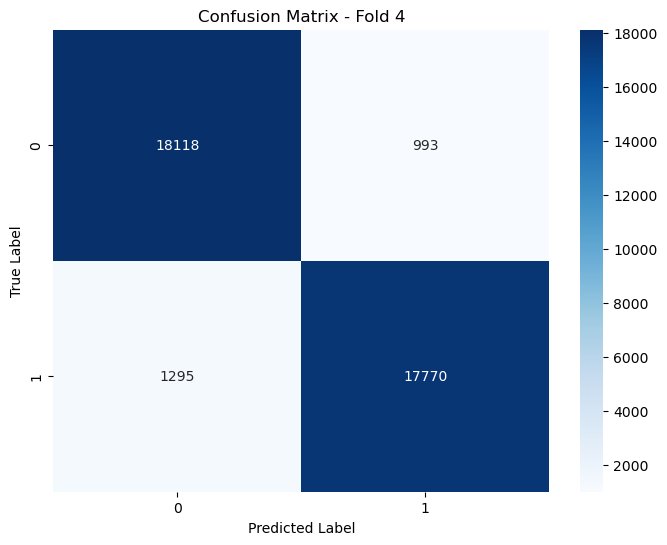


Classification Report - Fold 4
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     19111
           1       0.95      0.93      0.94     19065

    accuracy                           0.94     38176
   macro avg       0.94      0.94      0.94     38176
weighted avg       0.94      0.94      0.94     38176


Fold 5/5
----------------------------------------


Epoch 1/30
Train Loss: 0.2266 - Train Acc: 0.8887 - Val Loss: 0.1777 - Val Acc: 0.9146
----------------------------------------


Epoch 2/30
Train Loss: 0.1864 - Train Acc: 0.9089 - Val Loss: 0.1719 - Val Acc: 0.9190
----------------------------------------


Epoch 3/30
Train Loss: 0.1714 - Train Acc: 0.9152 - Val Loss: 0.1550 - Val Acc: 0.9220
----------------------------------------


Epoch 4/30
Train Loss: 0.1643 - Train Acc: 0.9193 - Val Loss: 0.1553 - Val Acc: 0.9204
----------------------------------------


Epoch 5/30
Train Loss: 0.1570 - Train Acc: 0.9238 - Val Loss: 0.1584 - Val Acc: 0.9297
----------------------------------------


Epoch 6/30
Train Loss: 0.1521 - Train Acc: 0.9278 - Val Loss: 0.1499 - Val Acc: 0.9286
----------------------------------------


Epoch 7/30
Train Loss: 0.1491 - Train Acc: 0.9297 - Val Loss: 0.1474 - Val Acc: 0.9296
----------------------------------------


Epoch 8/30
Train Loss: 0.1461 - Train Acc: 0.9318 - Val Loss: 0.1440 - Val Acc: 0.9325
----------------------------------------


Epoch 9/30
Train Loss: 0.1443 - Train Acc: 0.9326 - Val Loss: 0.1388 - Val Acc: 0.9363
----------------------------------------


Epoch 10/30
Train Loss: 0.1438 - Train Acc: 0.9338 - Val Loss: 0.1325 - Val Acc: 0.9381
----------------------------------------


Epoch 11/30
Train Loss: 0.1426 - Train Acc: 0.9348 - Val Loss: 0.1547 - Val Acc: 0.9322
----------------------------------------


Epoch 12/30
Train Loss: 0.1429 - Train Acc: 0.9336 - Val Loss: 0.1363 - Val Acc: 0.9349
----------------------------------------


Epoch 13/30
Train Loss: 0.1407 - Train Acc: 0.9354 - Val Loss: 0.1366 - Val Acc: 0.9371
----------------------------------------


Epoch 14/30
Train Loss: 0.1405 - Train Acc: 0.9351 - Val Loss: 0.1324 - Val Acc: 0.9400
----------------------------------------


Epoch 15/30
Train Loss: 0.1386 - Train Acc: 0.9359 - Val Loss: 0.1368 - Val Acc: 0.9349
----------------------------------------


Epoch 16/30
Train Loss: 0.1377 - Train Acc: 0.9366 - Val Loss: 0.1304 - Val Acc: 0.9387
----------------------------------------


Epoch 17/30
Train Loss: 0.1391 - Train Acc: 0.9359 - Val Loss: 0.1326 - Val Acc: 0.9393
----------------------------------------


Epoch 18/30
Train Loss: 0.1380 - Train Acc: 0.9359 - Val Loss: 0.1282 - Val Acc: 0.9408
----------------------------------------


Epoch 19/30
Train Loss: 0.1366 - Train Acc: 0.9371 - Val Loss: 0.1295 - Val Acc: 0.9409
----------------------------------------


Epoch 20/30
Train Loss: 0.1384 - Train Acc: 0.9367 - Val Loss: 0.1282 - Val Acc: 0.9402
----------------------------------------


Epoch 21/30
Train Loss: 0.1365 - Train Acc: 0.9365 - Val Loss: 0.1308 - Val Acc: 0.9393
----------------------------------------


Epoch 22/30
Train Loss: 0.1353 - Train Acc: 0.9374 - Val Loss: 0.1326 - Val Acc: 0.9397
----------------------------------------


Epoch 23/30
Train Loss: 0.1367 - Train Acc: 0.9370 - Val Loss: 0.1265 - Val Acc: 0.9407
----------------------------------------


Epoch 24/30
Train Loss: 0.1353 - Train Acc: 0.9379 - Val Loss: 0.1332 - Val Acc: 0.9358
----------------------------------------


Epoch 25/30
Train Loss: 0.1349 - Train Acc: 0.9379 - Val Loss: 0.1286 - Val Acc: 0.9406
----------------------------------------


Epoch 26/30
Train Loss: 0.1350 - Train Acc: 0.9381 - Val Loss: 0.1293 - Val Acc: 0.9406
----------------------------------------


Epoch 27/30
Train Loss: 0.1336 - Train Acc: 0.9379 - Val Loss: 0.1286 - Val Acc: 0.9408
----------------------------------------


Epoch 28/30
Train Loss: 0.1336 - Train Acc: 0.9383 - Val Loss: 0.1256 - Val Acc: 0.9412
----------------------------------------


Epoch 29/30
Train Loss: 0.1342 - Train Acc: 0.9385 - Val Loss: 0.1310 - Val Acc: 0.9395
----------------------------------------


Epoch 30/30
Train Loss: 0.1343 - Train Acc: 0.9377 - Val Loss: 0.1249 - Val Acc: 0.9418
----------------------------------------


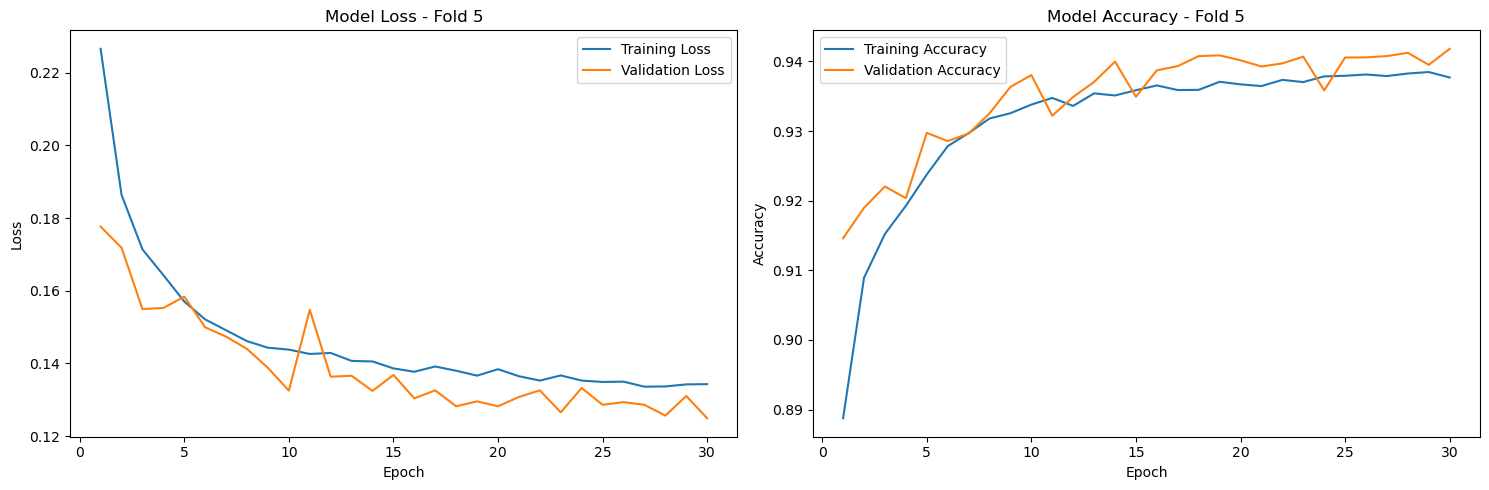

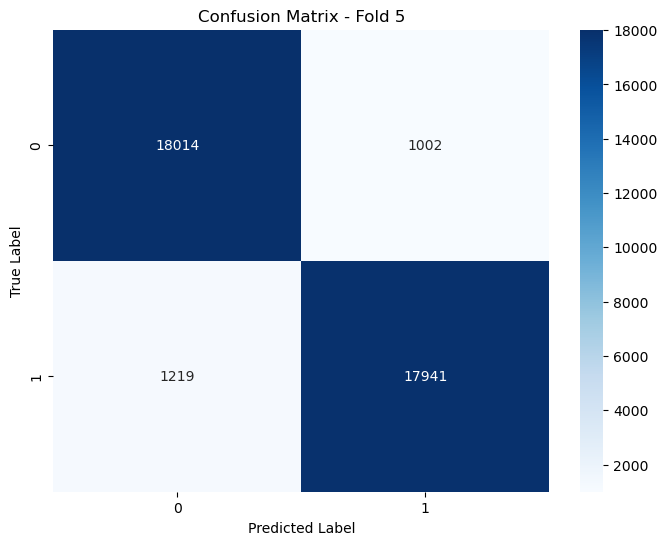


Classification Report - Fold 5
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     19016
           1       0.95      0.94      0.94     19160

    accuracy                           0.94     38176
   macro avg       0.94      0.94      0.94     38176
weighted avg       0.94      0.94      0.94     38176


Final Report
Best Fold: 5
Best Accuracy: 0.9418
Best Precision: 0.9419
Best Recall: 0.9418
Best F1 Score: 0.9418
Best Specificity: 0.9473
Best ROC-AUC: 0.9898


In [20]:
# Calculate dimensions for each modality
modality_dims = {
    modality: data.shape[1]
    for modality, data in balanced_train_data.items()
}

embed_dim = 128
nhead = 4
num_layers = 2
num_classes = 2

model = TransformerDecoderModel(
    modalities=modality_dims,
    embed_dim=embed_dim,
    nhead=nhead,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

tensor_train_data = {
    modality: torch.FloatTensor(data)
    for modality, data in balanced_train_data.items()
}
tensor_train_labels = torch.LongTensor(balanced_train_labels)

train_dataset = MultiModalDataset(tensor_train_data, tensor_train_labels)

model, history = train_model_with_kfold(
    model, train_dataset, n_splits=5, num_epochs=30
)